## Implementation of Reptile in Tensorflow 2.0

This implementation are influenced by :
- Pytorch implementation by Adrien Lucas Effot: [Paper repro: Deep Metalearning using “MAML” and “Reptile”](https://towardsdatascience.com/paper-repro-deep-metalearning-using-maml-and-reptile-fd1df1cc81b0)
- MAML implementation on Tensorflow 2.0 by Marianne Monteiro : [Reproduction of MAML using TensorFlow 2.0.](https://github.com/mari-linhares/tensorflow-maml)

Github : https://github.com/hfahrudin
Facebook : https://www.facebook.com/hasby.fahrudin

### Reptile : On First-Order Meta-Learning Algorithms

https://arxiv.org/abs/1803.02999

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend


import random
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
print('Python version: ', sys.version)
print('TensorFlow version: ', tf.__version__)
tf.keras.backend.set_floatx('float64')
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('GPU found at: {}'.format(device_name))

Python version:  3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 15:18:16) [MSC v.1916 64 bit (AMD64)]
TensorFlow version:  2.0.0
GPU found at: /device:GPU:0


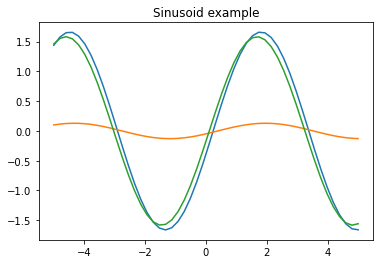

In [2]:
class SinusoidGenerator() :

    def __init__ (self, K=None, amplitude = None, phase = None):
        self.K = K
        self.amplitude = amplitude*2 if amplitude else np.random.uniform(0.1, 2.0)
        self.phase = phase*np.pi if phase else np.random.uniform(0,  0.2*np.pi)
        self.x = self._sample_x()
        
    def _sample_x(self):
        return np.random.uniform(-5,5, self.K)
    
    def f(self, x):
        return self.amplitude * np.sin(x - self.phase)
    
    def batch(self, x=None, force_new = False):
        if x is None:
            if force_new:
                x = self._sample_x()
            else:
                x = self.x
        y = self.f(x)
        return x[:, None], y[:, None]
    
    def equally_spaced_samples(self, K= None):
        if K is None:
            K = self.K
        return self.batch (x = np.linspace(-5, 5, K))
    
    def random_spaced_samples(self, K= None):
        if K is None:
            K = self.K
        return self.batch(x = np.random.uniform(-5, 5, K))

def plot (data, *args, **kwargs):
    x,y = data
    return plt.plot(x, y, *args, **kwargs)

plt.figure()
for _ in range(3):
    plt.title('Sinusoid example')
    plot(SinusoidGenerator(K=50).equally_spaced_samples())
plt.show()


In [3]:
def generate_dataset (K, train_size=1000, test_size=300):
    def _generate_dataset_train(size):
        return [SinusoidGenerator(K=K) for _ in range(size)]
    def _generate_dataset_test(size):
        return [SinusoidGenerator(K=K*2) for _ in range(size)]
    return _generate_dataset_train(train_size), _generate_dataset_test(test_size)


In [4]:
# t data
train_ds, _ = generate_dataset(K=100)

In [5]:
class SineModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden1 = keras.layers.Dense(40, input_shape=(1,))
        self.hidden2 = keras.layers.Dense(40)
        self.out = keras.layers.Dense(1)
        
    def forward(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = self.out(x)
        return x

In [12]:
def loss_function(pred_y, y):
    return keras_backend.mean(keras.losses.mean_squared_error(y, pred_y))

def np_to_tensor(list_of_numpy_objs):
    return (tf.convert_to_tensor(obj) for obj in list_of_numpy_objs)
    

def compute_loss(model, x, y, loss_fn=loss_function):
    logits = model.forward(x)
    mse = loss_fn(y, logits)
    return mse, logits
   
def train_batch(x, y, model, optimizer):
    tensor_x, tensor_y = np_to_tensor((x, y))
    with tf.GradientTape() as tape:
        loss, _ = compute_loss(model, x, y)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [7]:
def copy_model(model, x=None):
    '''Copy model weights to a new model.
    
    Args:
        model: model to be copied.
        x: An input example. This is used to run
            a forward pass in order to add the weights of the graph
            as variables.
    Returns:
        A copy of the model.
    '''
    
    copied_model = SineModel()
    
    # If we don't run this step the weights are not "initialized"
    # and the gradients will not be computed.
    copied_model.forward(tf.convert_to_tensor(x))
    
    copied_model.set_weights(model.get_weights())
    return copied_model


In [8]:
def train_reptile( epochs, dataset, mdl=None, lr_inner=0.001, lr_outer=0.01, batch_size=1, log_steps=100, k=3):
    if mdl is not None :
        model = mdl
    else:
        model = SineModel()
    inner_optimizer = keras.optimizers.SGD(learning_rate=lr_inner)
    outer_optimizer = keras.optimizers.Adam(learning_rate=lr_outer)
    losses = []
    
    for epoch in range(epochs):
        if log_steps is not None:
            print("====== Epoch : " +str(epoch)+ " ====== ")
        total_loss = 0
        
        start = time.time()
        # Step 3 and 4
        for i, t in enumerate(random.sample(dataset, len(dataset))):
            x, y = np_to_tensor(t.batch())
            model.forward(x) 
            
            old_weights = model.get_weights()
                
            model_copy = copy_model(model, x)
            for _ in range(k):
                loss = train_batch(x, y, model_copy, inner_optimizer)
            
            after_weights = model_copy.get_weights()

            step_size = lr_inner * (1 - epoch / epochs)
            new_weights = [ old_weights[i] + ((old_weights[i] - after_weights[i]) * step_size)
                           for i in range(len(model.weights))]
            
            model.set_weights(new_weights)
            
            if (i+1) % batch_size == 0:
                test_loss = train_batch(x, y, model, outer_optimizer)
            else:
                test_loss, logits = compute_loss(model, x, y)
            
            # Logs
            total_loss += test_loss
            loss = total_loss / (i+1.0)
            
            if log_steps is not None:
                if i % log_steps == 0 and i > 0:
                    print('Step {}: loss = {}, Time to run {} steps = {}'.format(i, loss, log_steps, time.time() - start))
                    start = time.time()
                    
        losses.append(loss)
    plt.plot(losses)
    plt.xlabel("Adaptation steps")
    plt.title("Mean Absolute Error Performance (REPTILE)")
    plt.ylabel("Loss")
    plt.show()
    return model, np.array(losses)

====== Epoch : 0 ====== 
Step 100: loss = 0.29673193121957586, Time to run 100 steps = 4.8799521923065186
Step 200: loss = 0.2503874878132261, Time to run 100 steps = 4.926827669143677
Step 300: loss = 0.24099504028604185, Time to run 100 steps = 5.0245726108551025
Step 400: loss = 0.23259018045114338, Time to run 100 steps = 5.145244359970093
Step 500: loss = 0.22196767608491372, Time to run 100 steps = 5.121307849884033
Step 600: loss = 0.2155622234425644, Time to run 100 steps = 5.240987539291382
Step 700: loss = 0.21874500099363076, Time to run 100 steps = 5.241985082626343
Step 800: loss = 0.2124818632733499, Time to run 100 steps = 5.14723801612854
Step 900: loss = 0.21394032596716056, Time to run 100 steps = 4.885936737060547
====== Epoch : 1 ====== 
Step 100: loss = 0.1885225956654919, Time to run 100 steps = 5.0544960498809814
Step 200: loss = 0.20019989387108822, Time to run 100 steps = 5.354673624038696
Step 300: loss = 0.19662960810912983, Time to run 100 steps = 5.06346201

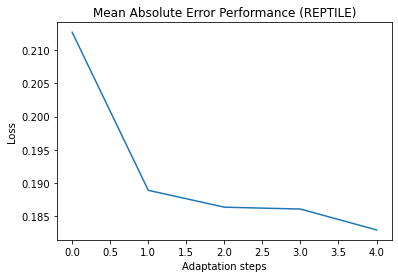

(<__main__.SineModel at 0x1b7f5788208>,
 array([0.21271617, 0.18888735, 0.18634281, 0.18605969, 0.18291432]))

In [13]:
train_reptile(5, train_ds)